# IRIS DATASET

## Preproccesing and converting of the IRIS Dataset to Torch Tensors


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

iris = load_iris()
X, y = iris.data[:, :3], iris.target  # Using only three characteristics

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

## SnnTorch Quantization Example

In [3]:
import torch
import math

class StateQuant(torch.autograd.Function):
    """Wrapper function for state quantization."""
    
    @staticmethod
    def forward(ctx, input_, levels):
        device = input_.device
        levels = levels.to(device)
        size = input_.size()
        input_ = input_.flatten()

        # Broadcast levels along a new dimension equal to the number of levels
        input_expanded = input_.unsqueeze(-1).repeat(1, levels.size(0))

        # Find the closest valid quantization state
        differences = torch.abs(levels - input_expanded)
        idx_match = torch.argmin(differences, dim=-1)
        quant_tensor = levels[idx_match]

        return quant_tensor.reshape(size)

    @staticmethod
    def backward(ctx, grad_output):
        # Straight Through Estimator (STE)
        grad_input = grad_output.clone()
        return grad_input, None

def state_quant(num_bits=8, uniform=True, thr_centered=True, threshold=1,
                lower_limit=0, upper_limit=0.2, multiplier=None):
    """Generate a quantization function with specified parameters."""
    num_levels = 2 ** num_bits  # Total number of quantization levels

    if uniform:
        # Uniform quantization
        levels = torch.linspace(
            -threshold * (1 + lower_limit),
            threshold * (1 + upper_limit),
            num_levels
        )
    else:
        # Non-uniform quantization
        if multiplier is None:
            # Default values based on number of bits
            multiplier = 0.05 + 0.9 * (num_bits - 1) / 15

        if thr_centered:
            # Centered around threshold
            max_val = threshold * (1 + upper_limit)
            min_val = -threshold * (1 + lower_limit)
        else:
            # Centered around zero
            max_val = threshold + threshold * upper_limit
            min_val = -threshold - threshold * lower_limit

        range_vals = torch.logspace(
            start=-multiplier * (num_levels - 1),
            end=0,
            steps=num_levels,
            base=10
        )
        levels = min_val + range_vals * (max_val - min_val)

    def inner(x):
        return StateQuant.apply(x, levels)

    return inner

# Example Usage
if __name__ == "__main__":
    num_bits = 4
    q_func = state_quant(num_bits=num_bits, uniform=True, threshold=5)

    # Sample input tensor
    x = torch.rand(10, 10) * 10 - 5  # Random values between -5 and 5
    quant_x = q_func(x)



## Two layers SNN for the IRIS Dataset

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import snntorch as snn
from brevitas.nn import QuantLinear
from brevitas.nn import QuantLinear
from brevitas.quant import Int8WeightPerTensorFixedPoint
from brevitas.core.quant import QuantType
from brevitas.nn import QuantLinear
from snntorch import functional as SF
from snntorch import functional as SF

beta = 0.9  # Membrane potential decay rate
num_steps = 5  # Number of time steps
hidden = 3 # Number of hidden neurons
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the quantization function for state variables
quant_func = state_quant(num_bits=8, uniform=True, threshold=1)

class IrisNetSNN(nn.Module):
    def __init__(self, timesteps, hidden, beta, quant_bit_width=8):
        super().__init__()
        self.timesteps = timesteps
        self.hidden = hidden
        self.beta = beta

        # Corrected Quantized linear layers using Brevitas
        self.fc1 = QuantLinear(3, hidden, bias=True, bit_width=quant_bit_width,
                               weight_quant_type=QuantType.INT, weight_bit_width=quant_bit_width)
        self.fc2 = QuantLinear(hidden, 3, bias=True, bit_width=quant_bit_width,
                               weight_quant_type=QuantType.INT, weight_bit_width=quant_bit_width)


        # Spiking neuron layers with quantized state variables
        self.rlif1 = snn.RLeaky(beta=self.beta, linear_features=self.hidden,
                                state_quant=state_quant(num_bits=8, uniform=True, threshold=1))
        self.rlif2 = snn.RLeaky(beta=self.beta, linear_features=3,
                                state_quant=state_quant(num_bits=8, uniform=True, threshold=1))

    def forward(self, x):
        spk1, mem1 = self.rlif1.init_rleaky()
        spk2, mem2 = self.rlif2.init_rleaky()
        spk_recording = []

        for step in range(self.timesteps):
            x = self.fc1(x)
            spk1, mem1 = self.rlif1(x, spk1, mem1)
            x = self.fc2(spk1)
            spk2, mem2 = self.rlif2(x, spk2, mem2)
            spk_recording.append(spk2)

        return torch.stack(spk_recording)

# Instantiate the model
model = IrisNetSNN(timesteps=num_steps, hidden=hidden, beta=beta).to(device)

# Print quantization parameters of weights
print("First layer weights quantization scale:", model.fc1.quant_weight_scale())
print("Second layer weights quantization scale:", model.fc2.quant_weight_scale())

# Setup optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

# Training loop
num_epochs = 15
model.train()
for epoch in range(num_epochs):
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)
        
        spk = model(data)  # forward-pass
        loss_val = loss_function(spk, targets)  # apply loss
        optimizer.zero_grad()  # zero out gradients
        loss_val.backward()  # calculate gradients
        optimizer.step()  # update weights

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss_val.item()}')

# Testing loop
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        
        spk = model(data)  # forward-pass
        predicted = spk.sum(dim=0).argmax(1)  # Predict the class with the highest spike count
        correct += (predicted == targets).float().sum()
        total += targets.shape[0]

print(f"Accuracy: {100 * correct / total:.2f}%")

First layer weights quantization scale: tensor(0.0045, grad_fn=<DivBackward0>)
Second layer weights quantization scale: tensor(0.0042, grad_fn=<DivBackward0>)
Epoch 0, Loss: 1.2000000476837158
Epoch 0, Loss: 1.2000000476837158
Epoch 0, Loss: 1.1600000858306885
Epoch 0, Loss: 1.1666667461395264
Epoch 0, Loss: 1.0199999809265137
Epoch 0, Loss: 0.9333332777023315
Epoch 0, Loss: 0.9266666173934937
Epoch 0, Loss: 1.0466666221618652
Epoch 0, Loss: 0.9399999380111694
Epoch 0, Loss: 0.8533333539962769
Epoch 0, Loss: 0.8866666555404663
Epoch 0, Loss: 1.0533334016799927
Epoch 10, Loss: 0.35333332419395447
Epoch 10, Loss: 0.24666666984558105
Epoch 10, Loss: 0.5733333230018616
Epoch 10, Loss: 0.24666666984558105
Epoch 10, Loss: 0.2800000011920929
Epoch 10, Loss: 0.35333332419395447
Epoch 10, Loss: 0.3466666638851166
Epoch 10, Loss: 0.3466666638851166
Epoch 10, Loss: 0.3199999928474426
Epoch 10, Loss: 0.4866666793823242
Epoch 10, Loss: 0.5600000023841858
Epoch 10, Loss: 0.4399999976158142
Accuracy:

              precision    recall  f1-score   support

           0       0.56      1.00      0.71        10
           1       1.00      0.11      0.20         9
           2       0.91      0.91      0.91        11

    accuracy                           0.70        30
   macro avg       0.82      0.67      0.61        30
weighted avg       0.82      0.70      0.63        30

Confusion Matrix:
[[10  0  0]
 [ 7  1  1]
 [ 1  0 10]]


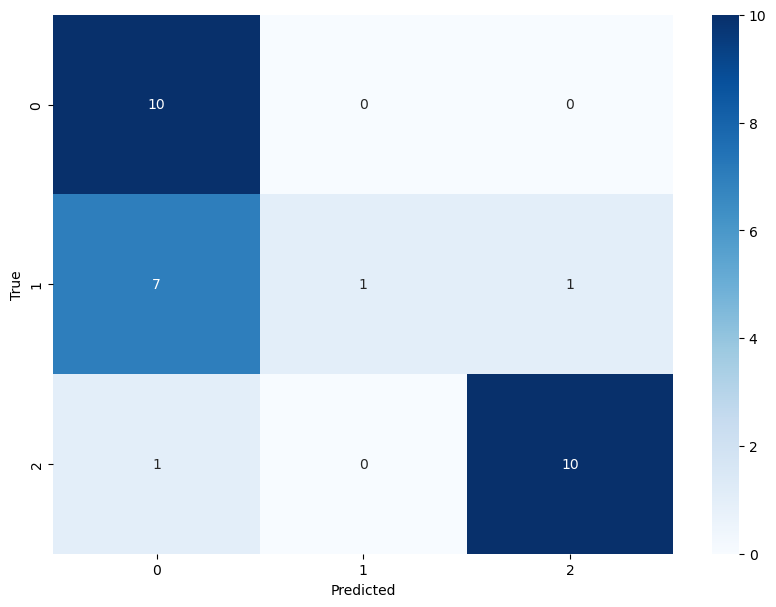

In [16]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        output = model(data)

        predicted = output.sum(dim=0).argmax(dim=1).cpu().numpy()
        targets = targets.cpu().numpy()

        all_preds.extend(predicted)
        all_targets.extend(targets)

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

print(classification_report(all_targets, all_preds))

cm = confusion_matrix(all_targets, all_preds)
print("Confusion Matrix:")
print(cm)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Results
### ACCURACY OF 70 PERCENT

## Quantized Weights for the Two layer Network

In [15]:
# Print the actual weights of the first layer
print("First layer weights:", model.fc1.weight.data)

# Print quantized weight scales for the first layer
print("First layer quantization scale:", model.fc1.quant_weight_scale())

# Check the quantized weights range and values
quantized_weights_fc1 = model.fc1.weight.data / model.fc1.quant_weight_scale()
print("Quantized values of first layer (scaled to integer range):", quantized_weights_fc1.int())

# Repeat the process for the second layer
print("Second layer weights:", model.fc2.weight.data)
print("Second layer quantization scale:", model.fc2.quant_weight_scale())
quantized_weights_fc2 = model.fc2.weight.data / model.fc2.quant_weight_scale()
print("Quantized values of second layer (scaled to integer range):", quantized_weights_fc2.int())


First layer weights: tensor([[-0.0965,  0.0776, -0.1958],
        [ 0.7045, -0.2719,  1.0020],
        [ 0.3190, -0.5579, -0.3130]])
First layer quantization scale: tensor(0.0079, grad_fn=<DivBackward0>)
Quantized values of first layer (scaled to integer range): tensor([[-12,   9, -24],
        [ 89, -34, 126],
        [ 40, -70, -39]], dtype=torch.int32)
Second layer weights: tensor([[ 0.6002, -0.6847, -0.0864],
        [ 0.9046, -0.5112,  0.1240],
        [ 0.4989,  0.7042,  0.0112]])
Second layer quantization scale: tensor(0.0071, grad_fn=<DivBackward0>)
Quantized values of second layer (scaled to integer range): tensor([[ 84, -96, -12],
        [127, -71,  17],
        [ 70,  98,   1]], dtype=torch.int32)


## Three Layers SNN for the IRIS Dataset

In [8]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import snntorch as snn
from brevitas.nn import QuantLinear
from brevitas.nn import QuantLinear
from brevitas.quant import Int8WeightPerTensorFixedPoint
from brevitas.core.quant import QuantType
from brevitas.nn import QuantLinear
from snntorch import functional as SF
from snntorch import functional as SF

beta = 0.9  # Membrane potential decay rate
num_steps = 3 # Number of time steps
hidden = 3 # Number of hidden neurons
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the quantization function for state variables
quant_func = state_quant(num_bits=8, uniform=True, threshold=1)

class IrisNetSNN(nn.Module):
    def __init__(self, timesteps, hidden, beta, quant_bit_width=8):
        super().__init__()
        self.timesteps = timesteps
        self.hidden = hidden
        self.beta = beta

        # Corrected Quantized linear layers using Brevitas
        self.fc1 = QuantLinear(3, hidden, bias=True, bit_width=quant_bit_width,
                               weight_quant_type=QuantType.INT, weight_bit_width=quant_bit_width)
                # Spiking neuron layers with quantized state variables
        self.rlif1 = snn.RLeaky(beta=self.beta, linear_features=self.hidden,
                                state_quant=state_quant(num_bits=8, uniform=True, threshold=1))
        
        
        self.fc2 = QuantLinear(hidden, 3, bias=True, bit_width=quant_bit_width,
                               weight_quant_type=QuantType.INT, weight_bit_width=quant_bit_width)
        self.rlif2 = snn.RLeaky(beta=self.beta, linear_features=3,
                                state_quant=state_quant(num_bits=8, uniform=True, threshold=1))
        
                
        self.fc3 = QuantLinear(hidden, 3, bias=True, bit_width=quant_bit_width,
                               weight_quant_type=QuantType.INT, weight_bit_width=quant_bit_width)
        self.rlif3 = snn.RLeaky(beta=self.beta, linear_features=3,
                                state_quant=state_quant(num_bits=8, uniform=True, threshold=1))

    def forward(self, x):
        spk1, mem1 = self.rlif1.init_rleaky()
        spk2, mem2 = self.rlif2.init_rleaky()
        spk3, mem3 = self.rlif3.init_rleaky()
        spk_recording = []

        for step in range(self.timesteps):
            x = self.fc1(x)
            spk1, mem1 = self.rlif1(x, spk1, mem1)
            x = self.fc2(spk1)
            spk2, mem2 = self.rlif2(x, spk2, mem2)
            x = self.fc3(spk2)
            spk3, mem3 = self.rlif3(x, spk3, mem3)
            spk_recording.append(spk3)

        return torch.stack(spk_recording)

# Instantiate the model
model = IrisNetSNN(timesteps=num_steps, hidden=hidden, beta=beta).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_function = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

# Training loop
num_epochs = 65
model.train()
for epoch in range(num_epochs):
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)
        
        spk = model(data)  
        loss_val = loss_function(spk, targets)  # apply loss
        optimizer.zero_grad()  # zero out gradients
        loss_val.backward()  # calculate gradients
        optimizer.step()  # update weights

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss_val.item()}')

# Testing loop
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        
        spk = model(data)  
        predicted = spk.sum(dim=0).argmax(1)  
        correct += (predicted == targets).float().sum()
        total += targets.shape[0]

print(f"Accuracy: {100 * correct / total:.2f}%")

Epoch 0, Loss: 0.4444444477558136
Epoch 0, Loss: 0.4444444477558136
Epoch 0, Loss: 0.4444444477558136
Epoch 0, Loss: 0.4444444477558136
Epoch 0, Loss: 0.4444444477558136
Epoch 0, Loss: 0.4444444477558136
Epoch 0, Loss: 0.4444444477558136
Epoch 0, Loss: 0.4444444477558136
Epoch 0, Loss: 0.4444444477558136
Epoch 0, Loss: 0.4444444477558136
Epoch 0, Loss: 0.4444444477558136
Epoch 0, Loss: 0.4444444477558136
Epoch 10, Loss: 0.2666666805744171
Epoch 10, Loss: 0.23333333432674408
Epoch 10, Loss: 0.32222220301628113
Epoch 10, Loss: 0.24444444477558136
Epoch 10, Loss: 0.277777761220932
Epoch 10, Loss: 0.3444444239139557
Epoch 10, Loss: 0.25555554032325745
Epoch 10, Loss: 0.2888889014720917
Epoch 10, Loss: 0.24444444477558136
Epoch 10, Loss: 0.17777778208255768
Epoch 10, Loss: 0.36666667461395264
Epoch 10, Loss: 0.25555554032325745
Epoch 20, Loss: 0.1666666716337204
Epoch 20, Loss: 0.17777778208255768
Epoch 20, Loss: 0.1111111119389534
Epoch 20, Loss: 0.1111111119389534
Epoch 20, Loss: 0.233333

## Results
### ACCURACY OF 100 PERCENT

 # Confusion Matrix of the IRIS Dataset

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


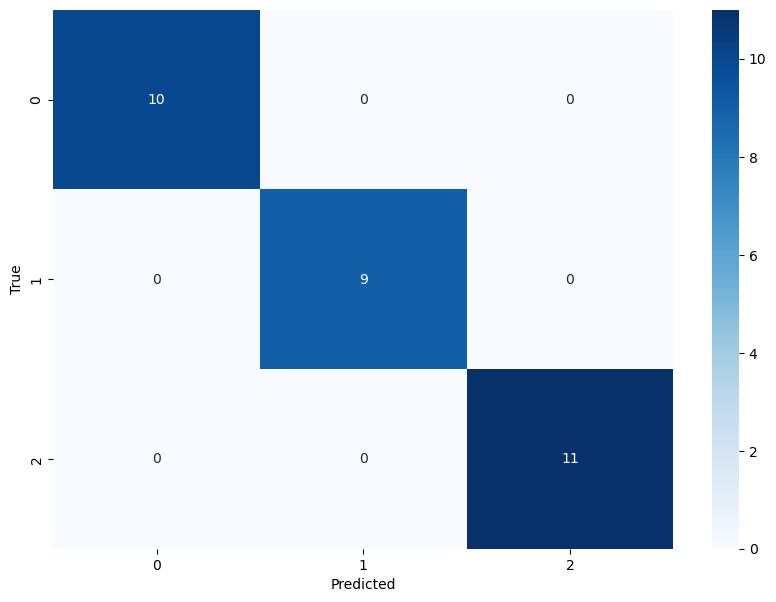

In [9]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        output = model(data)

        predicted = output.sum(dim=0).argmax(dim=1).cpu().numpy()
        targets = targets.cpu().numpy()

        all_preds.extend(predicted)
        all_targets.extend(targets)

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

print(classification_report(all_targets, all_preds))

cm = confusion_matrix(all_targets, all_preds)
print("Confusion Matrix:")
print(cm)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Quantized Weights for the Three layer Network


In [10]:
# Print the actual weights of the first layer
print("First layer weights:", model.fc1.weight.data)

# Print quantized weight scales for the first layer
print("First layer quantization scale:", model.fc1.quant_weight_scale())

# Check the quantized weights range and values
quantized_weights_fc1 = model.fc1.weight.data / model.fc1.quant_weight_scale()
print("Quantized values of first layer (scaled to integer range):", quantized_weights_fc1.int())

# Repeat the process for the second layer
print("Second layer weights:", model.fc2.weight.data)
print("Second layer quantization scale:", model.fc2.quant_weight_scale())
quantized_weights_fc2 = model.fc2.weight.data / model.fc2.quant_weight_scale()
print("Quantized values of second layer (scaled to integer range):", quantized_weights_fc2.int())


First layer weights: tensor([[ 1.4953,  0.2123,  2.3659],
        [ 0.0497,  0.0706, -0.7188],
        [-0.9167,  1.1306, -1.4000]])
First layer quantization scale: tensor(0.0186, grad_fn=<DivBackward0>)
Quantized values of first layer (scaled to integer range): tensor([[ 80,  11, 126],
        [  2,   3, -38],
        [-49,  60, -75]], dtype=torch.int32)
Second layer weights: tensor([[-0.3594,  0.6582,  1.1852],
        [ 0.7900, -0.6251,  1.0726],
        [ 0.2386, -0.0320, -1.4237]])
Second layer quantization scale: tensor(0.0112, grad_fn=<DivBackward0>)
Quantized values of second layer (scaled to integer range): tensor([[ -32,   58,  105],
        [  70,  -55,   95],
        [  21,   -2, -127]], dtype=torch.int32)


## XOR Problem

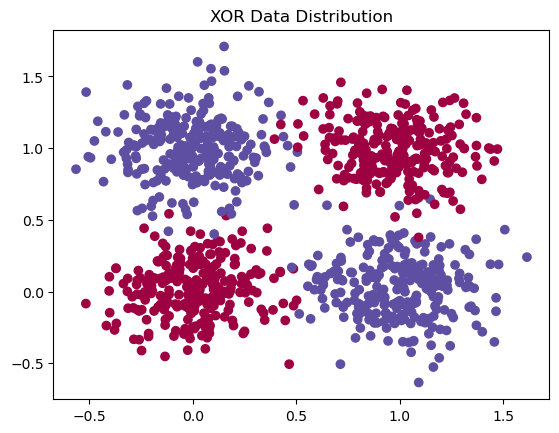

In [11]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Function to create XOR data
def make_xor(n_points):
    centers = np.array([[0,0],[0,1],[1,0],[1,1]])
    labels = np.array([0,1,1,0])
    data = np.array([]).reshape(-1,3)
    for center, label in zip(centers, labels):
        points = np.random.normal(loc=center, scale=0.2, size=(n_points//4, 2))
        points_labels = np.hstack((points, label*np.ones(n_points//4).reshape((-1, 1))))
        data = np.vstack((data, points_labels))
    return data[:, :2], data[:, 2]

X, y = make_xor(1000)
y = y.astype(np.int64)

# Splitting data into train, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=49) 

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader instances
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# Visualization of the XOR data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
plt.title("XOR Data Distribution")
plt.show()


## Three Layers SNN for the XOR problem

In [13]:
import torch.nn as nn
import snntorch as snn
from brevitas.nn import QuantLinear
from brevitas.quant import Int8WeightPerTensorFixedPoint
from brevitas.core.quant import QuantType

class IrisNetSNN(nn.Module):
    def __init__(self, timesteps, hidden, beta, quant_bit_width=8):
        super(IrisNetSNN, self).__init__()
        self.timesteps = timesteps
        self.hidden = hidden
        self.beta = beta

        # Define Quantized linear layers using Brevitas
        self.fc1 = QuantLinear(2, hidden, bias=True, bit_width=quant_bit_width,
                               weight_quant_type=QuantType.INT, weight_bit_width=quant_bit_width)
        self.rlif1 = snn.Leaky(beta=self.beta, learn_beta=True)
        
        self.fc2 = QuantLinear(hidden, hidden, bias=True, bit_width=quant_bit_width,
                               weight_quant_type=QuantType.INT, weight_bit_width=quant_bit_width)
        self.rlif2 = snn.Leaky(beta=self.beta, learn_beta=True)

        self.fc3 = QuantLinear(hidden, 2, bias=True, bit_width=quant_bit_width,  # Note: Output is 2 for binary classification
                               weight_quant_type=QuantType.INT, weight_bit_width=quant_bit_width)
        self.rlif3 = snn.Leaky(beta=self.beta, learn_beta=True)

    def forward(self, x):
        mem1 = self.rlif1.init_leaky()
        spk1 = torch.zeros_like(mem1)
        
        mem2 = self.rlif2.init_leaky()
        spk2 = torch.zeros_like(mem2)
        
        mem3 = self.rlif3.init_leaky()
        spk3 = torch.zeros_like(mem3)

        for step in range(self.timesteps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.rlif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.rlif2(cur2, mem2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.rlif3(cur3, mem3)

        return spk3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = IrisNetSNN(timesteps=3, hidden=3, beta=0.9).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.CrossEntropyLoss()

for epoch in range(30):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")



Test Accuracy: 96.50%


## Results
### ACCURACY OF 96.5 PERCENT

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        97
           1       0.98      0.95      0.97       103

    accuracy                           0.96       200
   macro avg       0.96      0.97      0.96       200
weighted avg       0.97      0.96      0.97       200

Confusion Matrix:
[[95  2]
 [ 5 98]]


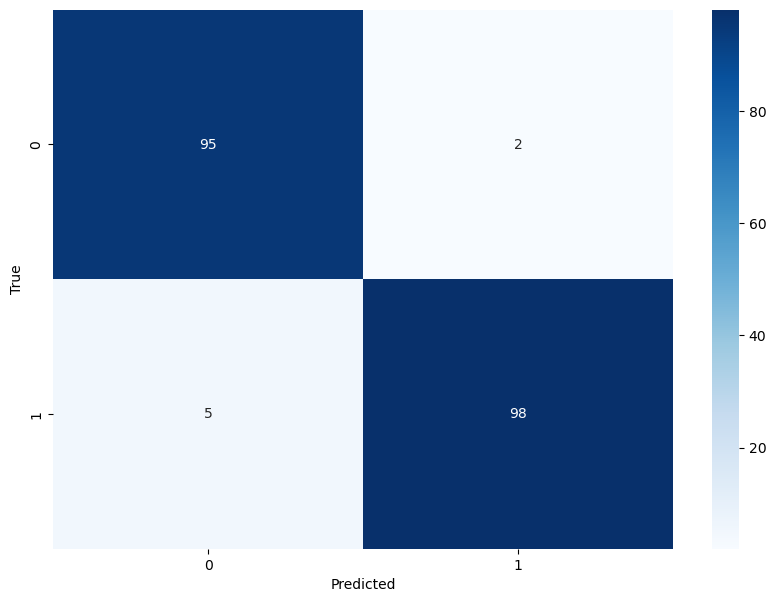

Test Accuracy: 96.50%


In [18]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        output = model(data)

        predicted = output.argmax(dim=1).cpu().numpy()
        targets = targets.cpu().numpy()

        all_preds.extend(predicted)
        all_targets.extend(targets)

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Classification report
print(classification_report(all_targets, all_preds))

# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculating accuracy
correct = (all_preds == all_targets).sum()
total = all_targets.shape[0]
print(f"Test Accuracy: {100 * correct / total:.2f}%")

## Quantized Weights for the Three layer Network for the XOR


In [14]:
# Print the actual weights of the first layer
print("First layer weights:", model.fc1.weight.data)

# Print quantized weight scales for the first layer
print("First layer quantization scale:", model.fc1.quant_weight_scale())

# Check the quantized weights range and values for the first layer
quantized_weights_fc1 = model.fc1.weight.data / model.fc1.quant_weight_scale()
print("Quantized values of first layer (scaled to integer range):", quantized_weights_fc1.int())

# Repeat the process for the second layer
print("Second layer weights:", model.fc2.weight.data)
print("Second layer quantization scale:", model.fc2.quant_weight_scale())
quantized_weights_fc2 = model.fc2.weight.data / model.fc2.quant_weight_scale()
print("Quantized values of second layer (scaled to integer range):", quantized_weights_fc2.int())

# Now, do the same for the third layer
print("Third layer weights:", model.fc3.weight.data)
print("Third layer quantization scale:", model.fc3.quant_weight_scale())
quantized_weights_fc3 = model.fc3.weight.data / model.fc3.quant_weight_scale()
print("Quantized values of third layer (scaled to integer range):", quantized_weights_fc3.int())


First layer weights: tensor([[-1.2820, -1.3223],
        [-1.6196,  0.8375],
        [ 0.9120, -1.7966]])
First layer quantization scale: tensor(0.0141, grad_fn=<DivBackward0>)
Quantized values of first layer (scaled to integer range): tensor([[ -90,  -93],
        [-114,   59],
        [  64, -127]], dtype=torch.int32)
Second layer weights: tensor([[ 1.6504, -0.0942, -0.8120],
        [-1.7612,  1.3037,  1.1659],
        [-2.1170,  2.2071,  1.3292]])
Second layer quantization scale: tensor(0.0174, grad_fn=<DivBackward0>)
Quantized values of second layer (scaled to integer range): tensor([[  94,   -5,  -46],
        [-101,   75,   67],
        [-121,  126,   76]], dtype=torch.int32)
Third layer weights: tensor([[ 1.5552, -1.2080, -1.7106],
        [-0.7479,  1.6252,  1.8017]])
Third layer quantization scale: tensor(0.0142, grad_fn=<DivBackward0>)
Quantized values of third layer (scaled to integer range): tensor([[ 109,  -85, -120],
        [ -52,  114,  127]], dtype=torch.int32)


# MUTLICLASS MNIST for the classes of 0 1 2

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import snntorch as snn
from brevitas.nn import QuantLinear
from brevitas.core.quant import QuantType
import torch.nn.functional as F

=device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def split_image_into_three(tensor):

    tensor = torch.nn.functional.pad(tensor, (0, 2), "constant", 0)  # Padding 2 pixels
    tensor = tensor.view(-1)  # Flatten the tensor
    section_size = tensor.size(0) // 3

    sections = []
    start_index = 0
    for _ in range(3):
        sections.append(tensor[start_index:start_index + section_size])
        start_index += section_size

    return torch.stack(sections)

transform = transforms.Compose([
    transforms.ToTensor(),
    split_image_into_three  
])


def filter_dataset(dataset):
    indices = [i for i, (img, label) in enumerate(dataset) if label in [0, 1, 2]]
    return Subset(dataset, indices)

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataset = filter_dataset(train_dataset)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dataset = filter_dataset(test_dataset)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

class MNISTNetSNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, timesteps, beta):
        super().__init__()
        self.timesteps = timesteps
        self.beta = beta
        
        self.fc1_sections = nn.ModuleList([
            QuantLinear(input_size, 1, bias=True, bit_width=8,
                        weight_quant_type=QuantType.INT, weight_bit_width=8) for _ in range(3)
        ])
        self.rlif1 = snn.Leaky(beta=self.beta)
        
        self.fc_mid = QuantLinear(3, 3, bias=True, bit_width=8,
                                  weight_quant_type=QuantType.INT, weight_bit_width=8)
        self.rlif_mid = snn.Leaky(beta=self.beta)
        
        self.fc2 = QuantLinear(3, output_size, bias=True, bit_width=8,
                               weight_quant_type=QuantType.INT, weight_bit_width=8)
        self.rlif2 = snn.Leaky(beta=self.beta)

    def forward(self, x):
        mem1 = [None] * 3
        mem_mid = None
        mem2 = None
        spk_recording = []

        for step in range(self.timesteps):
            spk1 = []
            for i, fc1 in enumerate(self.fc1_sections):
                cur1 = fc1(x[:, i, step].view(-1, 1))
                spk, mem = self.rlif1(cur1, mem1[i] if mem1[i] is not None else torch.zeros_like(cur1))
                spk1.append(spk)
                mem1[i] = mem

            spk1 = torch.cat(spk1, dim=1)  # Concatenate spikes from all sections

            cur_mid = self.fc_mid(spk1)
            spk_mid, mem_mid = self.rlif_mid(cur_mid, mem_mid if mem_mid is not None else torch.zeros_like(cur_mid))

            cur2 = self.fc2(spk_mid)
            spk2, mem2 = self.rlif2(cur2, mem2 if mem2 is not None else torch.zeros_like(cur2))

            spk_recording.append(spk2)

        return torch.stack(spk_recording, dim=0)

model = MNISTNetSNN(input_size=1, hidden_size=3, output_size=3, timesteps=262, beta=0.9).to(device)


def spike_count_loss(outputs, targets):
    outputs_summed = outputs.sum(dim=0)  # Sum across time dimension
    return F.cross_entropy(outputs_summed, targets)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = spike_count_loss

num_epochs = 25
model.train()
for epoch in range(num_epochs):
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, targets)
        loss.backward()
        optimizer.step()

        print(f'Epoch {epoch}, Loss: {loss.item()}')

model.eval()
total = 0
correct = 0
with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        output = model(data)
        predicted = output.sum(dim=0).argmax(dim=1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

print(f"Accuracy: {100 * correct / total:.2f}%")


Epoch 0, Loss: 27.703125
Epoch 0, Loss: 22.640625
Epoch 0, Loss: 22.8203125
Epoch 0, Loss: 24.5
Epoch 0, Loss: 24.3359375
Epoch 0, Loss: 20.0078125
Epoch 0, Loss: 20.4609375
Epoch 0, Loss: 22.21875
Epoch 0, Loss: 21.3359375
Epoch 0, Loss: 21.328125
Epoch 0, Loss: 21.09375
Epoch 0, Loss: 18.28125
Epoch 0, Loss: 20.6015625
Epoch 0, Loss: 18.25
Epoch 0, Loss: 20.1015625
Epoch 0, Loss: 18.0546875
Epoch 0, Loss: 20.109375
Epoch 0, Loss: 18.8984375
Epoch 0, Loss: 16.3046875
Epoch 0, Loss: 18.1796875
Epoch 0, Loss: 19.3046875
Epoch 0, Loss: 17.671875
Epoch 0, Loss: 18.5703125
Epoch 0, Loss: 15.8203125
Epoch 0, Loss: 17.4921875
Epoch 0, Loss: 17.2578125
Epoch 0, Loss: 15.6171875
Epoch 0, Loss: 14.90625
Epoch 0, Loss: 14.0078125
Epoch 0, Loss: 13.796875
Epoch 0, Loss: 13.6328125
Epoch 0, Loss: 14.21875
Epoch 0, Loss: 15.265625
Epoch 0, Loss: 13.9609375
Epoch 0, Loss: 13.4296875
Epoch 0, Loss: 13.5078125
Epoch 0, Loss: 11.9921875
Epoch 0, Loss: 13.203125
Epoch 0, Loss: 13.515625
Epoch 0, Loss: 1

In [4]:
torch.save(model.state_dict(), 'mnist_snn_model_weights.pth')

print("Model weights saved successfully.")


Model weights saved successfully.


 # Confusion Matrix of the Mnist Dataset for three Digits

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       980
           1       0.90      0.91      0.90      1135
           2       0.91      0.81      0.86      1032

    accuracy                           0.89      3147
   macro avg       0.89      0.89      0.89      3147
weighted avg       0.89      0.89      0.89      3147

Confusion Matrix:
[[ 919   18   43]
 [  59 1034   42]
 [  95   99  838]]


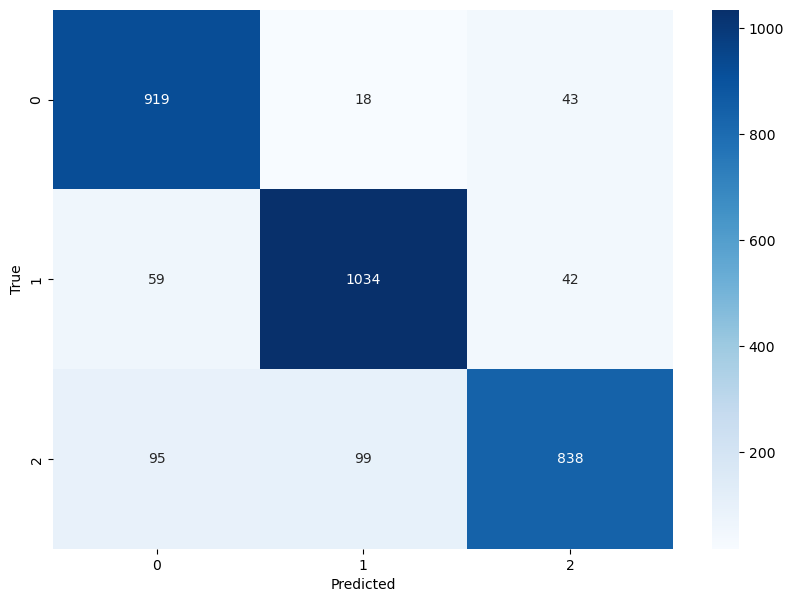

In [17]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.load_state_dict(torch.load('mnist_snn_model_weights.pth'))

model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        output = model(data)

        predicted = output.sum(dim=0).argmax(dim=1).cpu().numpy()
        targets = targets.cpu().numpy()

        all_preds.extend(predicted)
        all_targets.extend(targets)

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

print(classification_report(all_targets, all_preds))

cm = confusion_matrix(all_targets, all_preds)
print("Confusion Matrix:")
print(cm)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Results
### ACCURACY OF 89 PERCENT

### Quantized Weights of the MNIST Dataset 

In [7]:
for i, fc1 in enumerate(model.fc1_sections):
    print(f"First layer section {i+1} weights:", fc1.weight.data)
    print(f"First layer section {i+1} quantization scale:", fc1.quant_weight_scale())
    quantized_weights_fc1 = fc1.weight.data / fc1.quant_weight_scale()
    print(f"Quantized values of first layer section {i+1} (scaled to integer range):", quantized_weights_fc1.int())

print("Middle layer weights:", model.fc_mid.weight.data)
print("Middle layer quantization scale:", model.fc_mid.quant_weight_scale())
quantized_weights_mid = model.fc_mid.weight.data / model.fc_mid.quant_weight_scale()
print("Quantized values of middle layer (scaled to integer range):", quantized_weights_mid.int())

print("Second layer weights:", model.fc2.weight.data)
print("Second layer quantization scale:", model.fc2.quant_weight_scale())
quantized_weights_fc2 = model.fc2.weight.data / model.fc2.quant_weight_scale()
print("Quantized values of second layer (scaled to integer range):", quantized_weights_fc2.int())

First layer section 1 weights: tensor([[1.3622]])
First layer section 1 quantization scale: tensor(0.0107, grad_fn=<DivBackward0>)
Quantized values of first layer section 1 (scaled to integer range): tensor([[127]], dtype=torch.int32)
First layer section 2 weights: tensor([[-1.3166]])
First layer section 2 quantization scale: tensor(0.0104, grad_fn=<DivBackward0>)
Quantized values of first layer section 2 (scaled to integer range): tensor([[-126]], dtype=torch.int32)
First layer section 3 weights: tensor([[0.0663]])
First layer section 3 quantization scale: tensor(0.0005, grad_fn=<DivBackward0>)
Quantized values of first layer section 3 (scaled to integer range): tensor([[126]], dtype=torch.int32)
Middle layer weights: tensor([[-0.6052,  0.7243,  0.2030],
        [-2.0891, -0.7798,  0.4693],
        [ 0.2173,  0.3079, -0.5133]])
Middle layer quantization scale: tensor(0.0164, grad_fn=<DivBackward0>)
Quantized values of middle layer (scaled to integer range): tensor([[ -36,   44,   12],

# MNIST MODEL ON BINARY COMPARISON OF DIGITS 0 AND 1
with the quantized weights

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import snntorch as snn
from brevitas.nn import QuantLinear
from brevitas.core.quant import QuantType
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def split_image_into_three(tensor):
    tensor = torch.nn.functional.pad(tensor, (0, 2), "constant", 0)  # Padding 2 pixels
    tensor = tensor.view(-1)  # Flatten the tensor
    section_size = tensor.size(0) // 3

    sections = []
    start_index = 0
    for _ in range(3):
        sections.append(tensor[start_index:start_index + section_size])
        start_index += section_size

    return torch.stack(sections)

transform = transforms.Compose([
    transforms.ToTensor(),
    split_image_into_three  # Outputs a tensor of shape [3, 262]
])

# Loading and filtering datasets
def filter_dataset(dataset):
    indices = [i for i, (img, label) in enumerate(dataset) if label in [0, 1]]
    return Subset(dataset, indices)

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataset = filter_dataset(train_dataset)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dataset = filter_dataset(test_dataset)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

class MNISTNetSNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, timesteps, beta):
        super().__init__()
        self.timesteps = timesteps
        self.beta = beta
        
        self.fc1_sections = nn.ModuleList([
            QuantLinear(input_size, 1, bias=True, bit_width=8,
                        weight_quant_type=QuantType.INT, weight_bit_width=8) for _ in range(3)
        ])
        self.rlif1 = snn.Leaky(beta=self.beta)
        
        self.fc_mid = QuantLinear(3, 3, bias=True, bit_width=8,
                                  weight_quant_type=QuantType.INT, weight_bit_width=8)
        self.rlif_mid = snn.Leaky(beta=self.beta)
        
        self.fc2 = QuantLinear(3, output_size, bias=True, bit_width=8,
                               weight_quant_type=QuantType.INT, weight_bit_width=8)
        self.rlif2 = snn.Leaky(beta=self.beta)

    def forward(self, x):
        mem1 = [None] * 3
        mem_mid = None
        mem2 = None
        spk_recording = []

        for step in range(self.timesteps):
            spk1 = []
            for i, fc1 in enumerate(self.fc1_sections):
                cur1 = fc1(x[:, i, step].view(-1, 1))
                spk, mem = self.rlif1(cur1, mem1[i] if mem1[i] is not None else torch.zeros_like(cur1))
                spk1.append(spk)
                mem1[i] = mem

            spk1 = torch.cat(spk1, dim=1)

            cur_mid = self.fc_mid(spk1)
            spk_mid, mem_mid = self.rlif_mid(cur_mid, mem_mid if mem_mid is not None else torch.zeros_like(cur_mid))

            cur2 = self.fc2(spk_mid)
            spk2, mem2 = self.rlif2(cur2, mem2 if mem2 is not None else torch.zeros_like(cur2))

            spk_recording.append(spk2)

        return torch.stack(spk_recording, dim=0)

model = MNISTNetSNN(input_size=1, hidden_size=3, output_size=2, timesteps=262, beta=0.9).to(device)

# Cross Entropy Loss after summing spikes
def spike_count_loss(outputs, targets):
    outputs_summed = outputs.sum(dim=0)
    return F.cross_entropy(outputs_summed, targets)

# Optimizer and Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = spike_count_loss

num_epochs = 20
model.train()
for epoch in range(num_epochs):
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, targets)
        loss.backward()
        optimizer.step()

        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Save the model
torch.save(model.state_dict(), 'mnistbinary.pth')

model.eval()
total = 0
correct = 0
with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        output = model(data)
        predicted = output.sum(dim=0).argmax(dim=1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

print(f"Accuracy: {100 * correct / total:.2f}%")

# Load the model
model.load_state_dict(torch.load('mnistbinary.pth'))

# Print weights and quantization details
for i, fc1 in enumerate(model.fc1_sections):
    print(f"First layer section {i+1} weights:", fc1.weight.data)
    print(f"First layer section {i+1} quantization scale:", fc1.quant_weight_scale())
    quantized_weights_fc1 = fc1.weight.data / fc1.quant_weight_scale()
    print(f"Quantized values of first layer section {i+1} (scaled to integer range):", quantized_weights_fc1.int())

print("Middle layer weights:", model.fc_mid.weight.data)
print("Middle layer quantization scale:", model.fc_mid.quant_weight_scale())
quantized_weights_mid = model.fc_mid.weight.data / model.fc_mid.quant_weight_scale()
print("Quantized values of middle layer (scaled to integer range):", quantized_weights_mid.int())

print("Second layer weights:", model.fc2.weight.data)
print("Second layer quantization scale:", model.fc2.quant_weight_scale())
quantized_weights_fc2 = model.fc2.weight.data / model.fc2.quant_weight_scale()
print("Quantized values of second layer (scaled to integer range):", quantized_weights_fc2.int())


Epoch 0, Loss: 24.375
Epoch 0, Loss: 28.59375
Epoch 0, Loss: 30.0
Epoch 0, Loss: 28.578125
Epoch 0, Loss: 30.421875
Epoch 0, Loss: 29.90625
Epoch 0, Loss: 29.453125
Epoch 0, Loss: 23.109375
Epoch 0, Loss: 25.375
Epoch 0, Loss: 27.1875
Epoch 0, Loss: 25.375
Epoch 0, Loss: 24.015625
Epoch 0, Loss: 25.828125
Epoch 0, Loss: 24.0625
Epoch 0, Loss: 27.5625
Epoch 0, Loss: 27.5625
Epoch 0, Loss: 28.875
Epoch 0, Loss: 27.125
Epoch 0, Loss: 21.484375
Epoch 0, Loss: 26.640625
Epoch 0, Loss: 27.421875
Epoch 0, Loss: 29.109375
Epoch 0, Loss: 24.84375
Epoch 0, Loss: 28.03125
Epoch 0, Loss: 23.5625
Epoch 0, Loss: 28.4375
Epoch 0, Loss: 23.96875
Epoch 0, Loss: 21.125
Epoch 0, Loss: 24.78125
Epoch 0, Loss: 25.59375
Epoch 0, Loss: 23.15625
Epoch 0, Loss: 26.0
Epoch 0, Loss: 21.53125
Epoch 0, Loss: 19.90625
Epoch 0, Loss: 23.15625
Epoch 0, Loss: 23.96875
Epoch 0, Loss: 22.34375
Epoch 0, Loss: 22.75
Epoch 0, Loss: 30.875
Epoch 0, Loss: 28.515625
Epoch 0, Loss: 21.09375
Epoch 0, Loss: 26.03125
Epoch 0, Los

### Confusion Matrix and Classification report of the Binary Classification

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       980
           1       0.98      0.91      0.94      1135

    accuracy                           0.94      2115
   macro avg       0.94      0.94      0.94      2115
weighted avg       0.94      0.94      0.94      2115

Confusion Matrix:
[[ 958   22]
 [ 103 1032]]


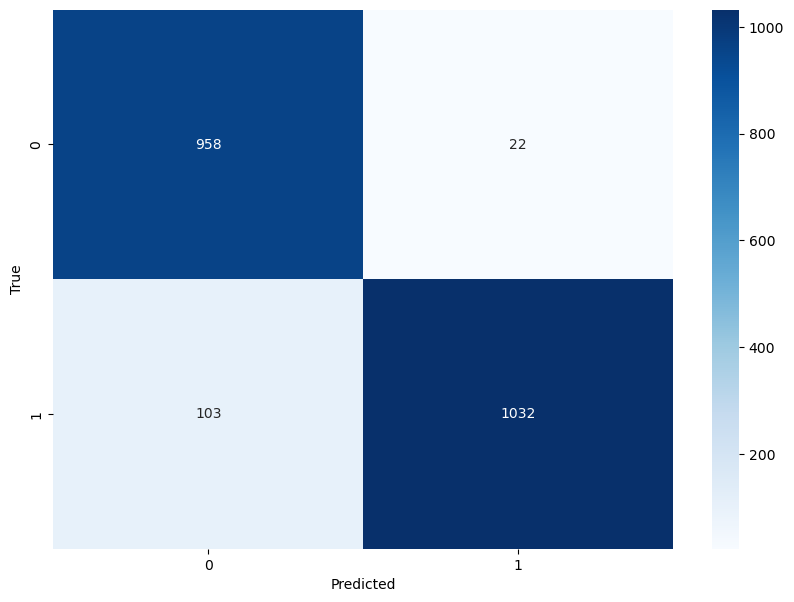

In [9]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.load_state_dict(torch.load('mnistbinary.pth'))

model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        output = model(data)

        predicted = output.sum(dim=0).argmax(dim=1).cpu().numpy()
        targets = targets.cpu().numpy()

        all_preds.extend(predicted)
        all_targets.extend(targets)

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

print(classification_report(all_targets, all_preds))

cm = confusion_matrix(all_targets, all_preds)
print("Confusion Matrix:")
print(cm)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Results
### ACCURACY OF 94 PERCENT